In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools

In [125]:
df_Pokemon = pd.read_csv('./Datasets/MP-24-25_Cleaned.csv')

### Lors de l'analyse univariée nous avions émis l'hypothèse que les variables taille et poids étaient corrélées. Visualisons la matrice des corrélations pour vérifier cela

In [126]:
quantitatives_vars = ['height', 'weight', 'total_points', 'catch_rate', 'base_experience']

In [127]:
df_Pokemon_quantitatives=df_Pokemon[quantitatives_vars]

In [128]:
matrices_correlation=df_Pokemon_quantitatives.corr()#Pearson par défaut

### Affichage à l'aide d'une heatmap

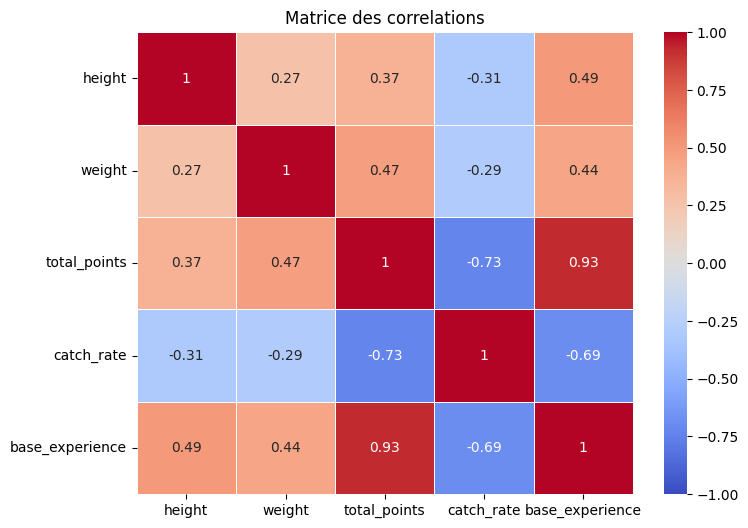

In [129]:
plt.figure(figsize=(8,6))
sns.heatmap(matrices_correlation,annot=True,cmap='coolwarm',vmin=-1,vmax=1,linewidths=0.5)
plt.title('Matrice des correlations')
plt.show()

### On constate une correlation qui est effectivement positive entre la taille et le poids, mais pas très elevée de 0.27. Cependant le coefficient calculé mesure la relation linéaire entre les deux variables ce qui n'est peut être pas le cas. On peut l'interpréter ainsi, quand le poids augmente la taille augmente aussi. On peut aussi représenter les deux variables à l'aide d'un nuage de points pour avoir si on a une relation linéaire


Nous avions émis l'hypothèse que les pokemons avec un nombre de points élevé avaient plus de chances d'etre légendaire.
Comment tester le lien entre la variable total_points et le statut?
On va réaliser une ANOVA qui est adaptée ici mais avant on va simplement visualiser la distrubution de total_points en fonction du statut


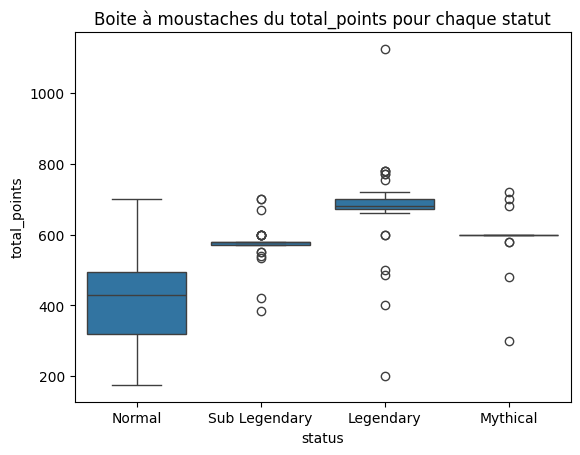

In [130]:
sns.boxplot(x='status',y='total_points',data=df_Pokemon)
plt.title("Boite à moustaches du total_points pour chaque statut")
plt.show()

### On constate des valeurs plus élevées pour les status semi-légendaire, legendaire et mythique


In [131]:
df_Pokemon['status'].value_counts()### beaucoup plus de Pokemons normal dans le dataset

status
Normal           918
Sub Legendary     55
Legendary         42
Mythical          30
Name: count, dtype: int64

In [132]:
def decision(pval):
    if pval<=0.05:### seuil par défaut
        return "On rejette H0 avec un seuil d'erreur de 5%"
    else:
        return "On ne rejette pas H0"


### Posons les hypothèses 
- H0: Pas de différences significatives de moyennes entre les status
- H1: il existe au moins un statut qui différe 

In [133]:
groupes = [df_Pokemon[df_Pokemon['status'] == statut]['total_points'] for statut in df_Pokemon['status'].unique()]


In [134]:
 f_stat, p_value = f_oneway(*groupes)#On suppose les hypothese pour appliquer le test valides

In [135]:
p_value# p-value calculée

1.49719602590481e-79

In [136]:
decision(p_value)

"On rejette H0 avec un seuil d'erreur de 5%"

### On va completer l'ANOVA qui ne donne pas les groupes ici les statuts qui diffèrent

In [137]:
status=df_Pokemon['status'].unique()#modalités differentes pour la variable status

In [138]:
paires=list(itertools.combinations(status,2))#toutes les paires de status à tester
len(paires)

6

In [139]:
for g1,g2 in paires:
    print(g1,g2)# affiche la paire de status tester
    points1=df_Pokemon[df_Pokemon['status']==g1]['total_points']
    points2=df_Pokemon[df_Pokemon['status']==g1]['total_points']
    t_stat, p_val = ttest_ind(points1, points2, equal_var=False)###H0 les moyennes de deux groupes compares sont identiques H1:elles sont differentes
    print(decision(p_val))
    

Normal Sub Legendary
On ne rejette pas H0
Normal Legendary
On ne rejette pas H0
Normal Mythical
On ne rejette pas H0
Sub Legendary Legendary
On ne rejette pas H0
Sub Legendary Mythical
On ne rejette pas H0
Legendary Mythical
On ne rejette pas H0


l'ANOVA a detectée une différence globale entre les statuts mais on n'a pas identifie les status qui different avec les tests réalisés ci-dessus

In [141]:
# Test de Tukey
tukey = pairwise_tukeyhsd(endog=df_Pokemon['total_points'],
                          groups=df_Pokemon['status'],
                          alpha=0.05)

print(tukey)
#print(type(tukey))

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1      group2     meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------
Legendary      Mythical  -80.6429 0.0056 -143.6062  -17.6795   True
Legendary        Normal -260.0459    0.0 -301.6079 -218.4839   True
Legendary Sub Legendary  -98.7823    0.0 -152.7565   -44.808   True
 Mythical        Normal -179.4031    0.0 -228.2715 -130.5346   True
 Mythical Sub Legendary  -18.1394 0.8632  -77.9219   41.6431  False
   Normal Sub Legendary  161.2637    0.0  124.6991  197.8282   True
-------------------------------------------------------------------
<class 'statsmodels.sandbox.stats.multicomp.TukeyHSDResults'>


Les seules groupes qui ne présentent pas de differences sont mythiques et semi-légendaires. La variable total_points permet bien de differencier les status entre eux ce qui  est cohérent